<a href="https://colab.research.google.com/github/gurnoor6/opponent-modelling/blob/main/Opponent_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import shutil, os
# shutil.rmtree("game_logs")
shutil.unpack_archive('game_logs.zip', './')
shutil.unpack_archive('validation.zip', './')
print(len(os.listdir('game_logs')))
print(len(os.listdir('validation')))
train_filenames = os.listdir('game_logs')
val_filenames = os.listdir('validation')
print(train_filenames[0], val_filenames[0])

28005
19123
400927.npz 400927.npz


In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
# Constants
T = 1 # Number of Timesteps for which boards are present in input
N = 8 # board size
HIDDEN_LAYER = 1 # hidden layer will be N * N * HIDDEN_LAYER neurons long
OUTPUT_LAYER = 73 # output layer will be N * N * OUTPUT_LAYER neurons long
BLOCKS = 10
FILTERS = 128

In [43]:
import numpy as np

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, filenames, batch_size) :
    self.filenames = filenames
    self.batch_size = batch_size
    self.randomize = True
    
    
  def __len__(self) :
    return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(int)
  
  
  def __getitem__(self, idx) :
    filenames = self.filenames[idx * self.batch_size : (idx+1) * self.batch_size]

    inputs = []
    outputs = []
    for f in filenames:
      if not f.endswith('.npz'): continue
      loaded = np.load(os.path.join('game_logs',f))
      length = len(loaded['inputs'])
      index = np.random.choice(length, length,replace=False)
      if randomize:
        index = np.random.choice(length, min(3, length), replace = False)
      inputs.extend(loaded['inputs'][index])
      outputs.extend(loaded['outputs'][index])
    
    Y_new = []
    for item in outputs: Y_new.append(item.flatten())
    
    # print(np.array(inputs).shape, np.array(Y_new).shape)
    return np.array(inputs), np.array(Y_new)

In [ ]:
import os
import numpy as np
import random
import tqdm
inputs = []
outputs = []
files = [f for f in os.listdir("game_logs") if os.path.splitext(f)[-1][1:] == 'npz']

# N_RANDOMIZE = 3
def get_N_RANDOMIZE():
  "50% of times returns 3 and 4"
  if np.random.uniform() <= 1: return 3
  return 4

idx = 0
randomize = False

for f in tqdm.tqdm(files):
  loaded = np.load(os.path.join('game_logs',f))
  length = len(loaded['inputs'])
  index = np.random.choice(length, length,replace=False)
  if randomize:
    index = np.random.choice(length, min(get_N_RANDOMIZE(), length), replace = False)
  inputs.extend(loaded['inputs'][index])
  outputs.extend(loaded['outputs'][index])
  idx += 1
  if idx > 4000 and not randomize:
    break

# clear RAM
files = []

 14%|█▍        | 4000/28004 [00:25<02:35, 153.96it/s]


In [ ]:
for i in range(len(inputs)):
  x = inputs[i]
  if x.shape != (8, 8, 14 * T):
    print(i)

print("Shape not matching done")
print(len(inputs))
print(inputs[0].shape)
print(np.array(inputs).shape)
print(outputs[0].shape)
print(np.array(outputs).shape)

Shape not matching done
88501
(8, 8, 14)
(88501, 8, 8, 14)
(8, 8, 73)
(88501, 8, 8, 73)


In [ ]:
X = np.array(inputs)
inputs = []
Y = np.array(outputs)
outputs = []

Y_new = []
for i in range(len(Y)):
  Y_new.append(Y[i].flatten())
Y = np.array(Y_new)
Y_new = []

print(X.shape)
print(Y.shape)
p = np.random.permutation(len(X))
train_test_ratio = 0.8
len_train = int(train_test_ratio * len(X))
X_train = X[:len_train, :, :]
Y_train = Y[:len_train, :]
X_val = X[len_train:, :, :]
Y_val = Y[len_train:, :]
X = []
Y = []

(88501, 8, 8, 14)
(88501, 4672)


In [45]:
batch_size = 64

training_generator = My_Custom_Generator(train_filenames, batch_size)
validation_generator = My_Custom_Generator(val_filenames, batch_size)

In [23]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(32, activation='softmax'), # small number chosen to avoid a lot of parameters
#   tf.keras.layers.Dense(N * N * OUTPUT_LAYER) # output number is fixed
# ])
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu', input_shape = (8, 8, 14 * T), strides = 1, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(73, (1,1), activation = 'relu', strides = 1, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Softmax()
    
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 8, 8, 256)         32512     
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 8, 8, 256)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 8, 8, 128)        

In [40]:
inputs = tf.keras.Input(shape=(8, 8, 14))
x1 = tf.keras.layers.LeakyReLU()(inputs)

x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x1)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Conv2D(14, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)

added = tf.keras.layers.add([x1, x])
x = tf.keras.layers.LeakyReLU()(added)

x = tf.keras.layers.Conv2D(73, (3,3),activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, x)
model.summary()
# tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 8, 8, 14)]   0           []                               
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 8, 8, 14)     0           ['input_5[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 8, 8, 128)    16256       ['leaky_re_lu_16[0][0]']         
                                                                                                  
 batch_normalization_18 (BatchN  (None, 8, 8, 128)   512         ['conv2d_18[0][0]']              
 ormalization)                                                                              

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

In [ ]:
history = model.fit_generator(generator=training_generator,
                   steps_per_epoch = int(len(train_filenames) // batch_size),
                   epochs = 50,
                   verbose = 1,
                   validation_data = validation_generator,
                   validation_steps = int(len(val_filenames) // batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
310/437 [====================>.........] - ETA: 1:14 - loss: 3.7301 - categorical_accuracy: 0.1798

In [13]:
history = model.fit(
    X_train, Y_train,
    epochs = 50,
    validation_data=(X_val, Y_val),
)

Epoch 1/50
2213/2213 [==============================] - 35s 11ms/step - loss: 4.4444 - categorical_accuracy: 0.1472 - val_loss: 4.0416 - val_categorical_accuracy: 0.1219
Epoch 2/50
2213/2213 [==============================] - 24s 11ms/step - loss: 3.6397 - categorical_accuracy: 0.1933 - val_loss: 3.7889 - val_categorical_accuracy: 0.1560
Epoch 3/50
2213/2213 [==============================] - 24s 11ms/step - loss: 3.4629 - categorical_accuracy: 0.2106 - val_loss: 3.6878 - val_categorical_accuracy: 0.1574
Epoch 4/50
2213/2213 [==============================] - 25s 11ms/step - loss: 3.3544 - categorical_accuracy: 0.2228 - val_loss: 3.6820 - val_categorical_accuracy: 0.1641
Epoch 5/50
2213/2213 [==============================] - 25s 11ms/step - loss: 3.2818 - categorical_accuracy: 0.2322 - val_loss: 3.6729 - val_categorical_accuracy: 0.1767
Epoch 6/50
2213/2213 [==============================] - 24s 11ms/step - loss: 3.2250 - categorical_accuracy: 0.2399 - val_loss: 3.6230 - val_categoric

KeyboardInterrupt: ignored

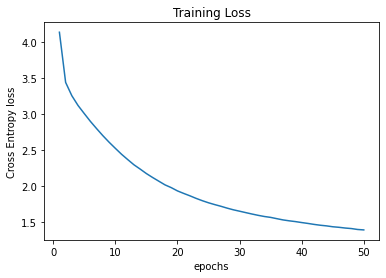

In [ ]:
# Plot the loss a sa function of number of epochs
import matplotlib.pyplot as plt
plt.title('Training Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['loss'])))),  history.history['loss'])

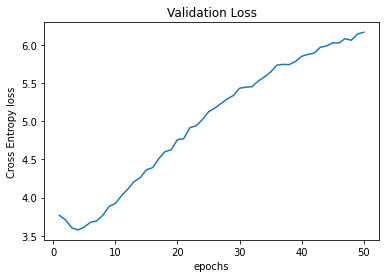

In [ ]:
# Plot the loss a sa function of number of epochs
plt.title('Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Cross Entropy loss')
plt.plot(list(map(lambda x: x+1, range(len(history.history['val_loss'])))),  history.history['val_loss'])

In [ ]:
print(history.history)

{'loss': [4.779267311096191, 3.784074068069458, 3.507483959197998, 3.3029396533966064, 3.1197621822357178, 2.957887887954712, 2.8069281578063965, 2.6582698822021484, 2.522676706314087, 2.3968281745910645, 2.2866437435150146, 2.189023971557617, 2.0999765396118164, 2.016209602355957, 1.9496568441390991, 1.8870676755905151, 1.8260600566864014, 1.7823654413223267, 1.7368017435073853, 1.6903678178787231, 1.6583510637283325, 1.6243596076965332, 1.5978574752807617, 1.5713759660720825, 1.545009732246399, 1.5166569948196411, 1.4909110069274902, 1.4754343032836914, 1.4513845443725586, 1.4342386722564697, 1.417296290397644, 1.402553677558899, 1.387212872505188, 1.374686598777771, 1.3584736585617065, 1.3480411767959595, 1.3329054117202759, 1.324205756187439, 1.3058209419250488, 1.3022949695587158], 'categorical_accuracy': [0.11208400875329971, 0.1655864417552948, 0.19465909898281097, 0.22136357426643372, 0.24710208177566528, 0.2711890935897827, 0.30185091495513916, 0.3288046717643738, 0.3561012148